# Geometric Tensor Learning
---

In [1]:
import numpy as np
import numpy.ma as ma
from numpy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx

import project_path

from util.t2m import t2m
from util.m2t import m2t
from util.update_L_nograd import update_L
from util.update_L_nograd import fn_val as fnval_L
from util.update_X_nograd import update_X
from util.update_X_nograd import fn_val as fnval_X
from util.update_Sigma import update_Sigma
from util.update_Lambda_nograd import update_Lambda
from util.update_Sigma import fn_val as fnval_Sigma
from util.generate_data import generate_syn_data
from util.contaminate_data import contaminate_signal
from util.fn_vals import fn_val_L
from util.fn_vals import fn_val_G

In [2]:
sizes = (10,10,10,10)
ranks = (3,3,3,3)
n = len(sizes)

## Generate Graphs
In this part, we create Erdos-Renyi graphs for each mode.

In [3]:
G = [nx.erdos_renyi_graph(sizes[i],0.3) for i in range(n)] # List of graphs for each mode
Phi = [nx.laplacian_matrix(G[i]).todense() for i in range(n)]


In [4]:
def graph_filter(Lambda, filter_length=3):
    ''' Graph filter generating the graph stationary data.
    '''
    h = np.random.rand(filter_length)
    return sum(h[i]**i*Lambda**i for i in range(filter_length))

## Data Generation Methods

In this part, we try to generate data smooth and stationary on the product graph.

In [5]:
# # Generate data by sampling using covariances of each mode generated with graph filters H.
# covs = []
# X_smooth = np.zeros(sizes)
# for i in range(n):
#     W, V = np.linalg.eigh(Phi[i])
#     eigs = graph_filter(W)
#     H = V@np.diag(eigs)@V.transpose()
#     covs.append(H @ H)

#     col_inds = np.setdiff1d(np.arange(n), 1)
#     sz = np.array(sizes)
#     sz_cols = np.prod(sz[col_inds])
#     mean_temp = np.zeros(Phi[i].shape[0])
#     Xmat = np.random.multivariate_normal(mean_temp, covs[i], sz_cols).transpose()
#     X_smooth = X_smooth + m2t(Xmat, sizes, i)

In [6]:
## Generate data by multiplying the graph filter with white Gaussian noise.
# X_smooth = generate_syn_data(sizes, ranks)
# V_all = 1

# covs = []
# X_smooth = np.zeros(sizes)
# for i in range(n):
#     W, V = np.linalg.eigh(Phi[i])
#     if not(i):
#         W_all = W
#     else:
#         W_all = np.kron(np.ones(W.size), W_all) + np.kron(W,np.ones(W_all.size).flatten('F'))
#     V_all = np.kron(V_all, V)

# X_stat = np.tensordot(H, np.random.randn(H.shape[1]), axes=([1],[0])).reshape(sizes)
# del W_all, V_all, H, eigs


In [7]:
## Generate data by multiplying the eigenvectors of the Graph Laplacian
# with i.i.d. Gaussian noise with variance given by the eigenvalues of the Laplacian.

V = []
for i in range(n):
    w, temp_v = np.linalg.eig(Phi[i])
    ind = np.argsort(w)
    V.append(temp_v[:,ind])
    if not(i):
        W_all = w[ind]
    else:
        W_all = np.kron(np.ones(w.size), W_all) + np.kron(w[ind],np.ones(W_all.size).flatten('F'))

C = (np.random.randn(np.prod(sizes))/(W_all+10**-4)).reshape(sizes)

X_smooth = C.copy()
for i in range(n):
    X_smooth = m2t(V[i]*t2m(X_smooth,i), sizes, i)

Let's see how smooth the data is compared to a random signal with similar Frobenius norm.

In [8]:
print(np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i)))
random_signal = np.random.randn(X_smooth.size).reshape(sizes)
random_signal = random_signal * norm(X_smooth)/norm(random_signal)
print(np.trace(t2m(random_signal,i).transpose()@Phi[i]@t2m(random_signal,i)))

120253837.05303374
1149754966.0117092


Let's see how stationarity looks like.

C:\Users\emres\AppData\Local\Temp/ipykernel_6464/1363646499.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(cov))


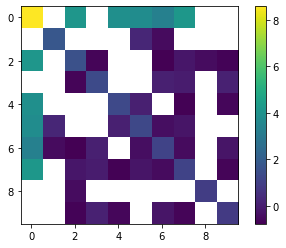

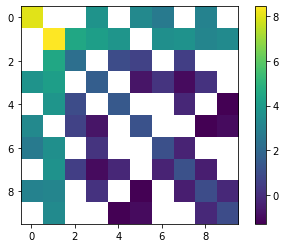

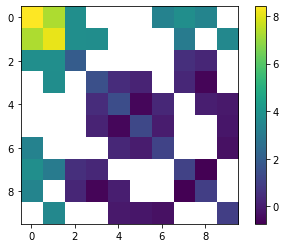

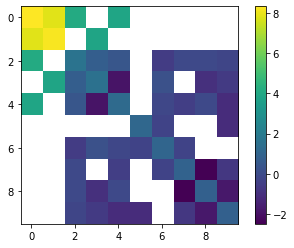

In [9]:
for i in range(n):
    P_X = V[i].transpose()@t2m(X_smooth,i)
    cov = P_X@P_X.transpose()
    plt.imshow(np.log10(cov))
    plt.colorbar()
    plt.show()

Cartesian graph eigenvalues.

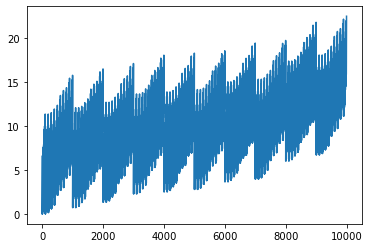

In [10]:
plt.plot(W_all)
plt.show()

## The Algorithm

In below, we add noise to data and run our algorithm to recover the original signal back.

In [161]:
def initialize_nograd(n, sizes):
    # Parameters
    alpha = [[10**-1 for i in range(n)], 
        [10**-1 for i in range(n)], 
        [10**-1 for i in range(n)], 
        [10**-9 for i in range(n)]]
    theta = [10**-10.5 for i in range(n)]
    gamma = [10**-1 for i in range(n)]

    # Initializations
    L = np.zeros(sizes)
    G_var = [np.zeros(sizes) for i in range(n)]
    X = [np.zeros(sizes) for i in range(n)]
    Lx = [np.zeros(sizes) for i in range(n)]
    Sigma = []
    for i in range(n):
        temp = np.random.standard_normal(sizes[i]**2).reshape([sizes[i], sizes[i]])
        Sigma.append(temp@temp.transpose())

    Lambda = [[np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros([sizes[i],sizes[i]]) for i in range(n)]]
    
    return L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma

In [162]:
L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma = initialize_nograd(n, sizes)

In [163]:
# Function value for original X
X_rep = [X_smooth for i in range(n)]
err_orig = fn_val_L(X_smooth, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X_smooth, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X_smooth,i)@t2m(X_smooth,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

print('Function value of original signal: {:.1e}'.format(err_orig))
print('Function value of original signal: {:.1e}'.format(sum(smooth_orig)))
print('Function value of original signal: {:.1e}'.format(sum(comm_orig)))

Function value of original signal: 1.2e+07
Function value of original signal: 1.2e+07
Function value of original signal: 5.5e+05


In [164]:
# Contaminate data.
Y = contaminate_signal(X_smooth, target_SNR=15)

In [165]:
G_inv = [np.linalg.inv(gamma[i]*Phi[i] + alpha[0][i]*np.identity(sizes[i])) for i in range(n)]
max_iter = 1000
iter = 0
fval_tot = []
# ADMM Loop
while True:
    # L Update
    prev_val = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[0]
    temp = np.zeros(sizes)
    for i in range(n):
        temp += alpha[0][i]*(G_var[i] + Lambda[0][i])
        temp += alpha[1][i]*(Lx[i] + Lambda[1][i])
    L = temp/(1+sum(alpha[0]) + sum(alpha[1]))
    L[~Y.mask] = L[~Y.mask] + Y[~Y.mask]/(sum(alpha[0]) + sum(alpha[1]) + 1)
    fval_data = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])
    fval_data_change = fval_data[0]-prev_val
    
    # G Update
    prev_val = fn_val_G(G_var, L, Phi, Lambda[0], alpha[0], gamma)[0]
    G_var = [m2t(alpha[0][i]*G_inv[i]*t2m(L-Lambda[0][i], i), sizes, i) for i in range(n)]
    fval_G = fn_val_G(G_var, L, Phi, Lambda[0], alpha[0], gamma)
    fval_G_change = fval_G[0] - prev_val

    # Lx Update
    prev_val = fnval_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:])[0]
    Lx, fval_L, fval_low, _, _ = update_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:], track_fval=True)
    fval_L_change = fval_L - prev_val

    # X Update
    prev_val = sum(fnval_X(X,Lx,Lambda[2:],Sigma,alpha[2:])[1])
    X, _, fval_X, _ = update_X(X, Lx, Lambda[2:], Sigma, alpha[2:], track_fval=True)
    fval_X_change = sum(fval_X) - prev_val

    # Sigma Update 
    prev_val = fnval_Sigma(Sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[0]
    Sigma, fval_Sigma, _, _ = update_Sigma(Sigma, Lx, X, Phi, Lambda[3], alpha[3], theta, track_fval=True)
    fval_Sigma_change = fval_Sigma - prev_val
    
    fval_tot.append(fval_data[1] + fval_G[0] + sum(fval_low) + sum(fval_X) + fval_Sigma)
    print('Objective function changes for L: {:.2e}, G: {:.2e}, Lx: {:.2e}, X: {:.2e}, Sigma: {:.2e}'.format(
        fval_data_change,
        fval_G_change,
        fval_L_change,
        fval_X_change,
        fval_Sigma_change
    ))
    print('Total Objective Function Value at iter {}: {}'.format(iter, fval_tot[-1]))
    # Dual Update
    Lambda = update_Lambda(Lambda,L,Lx,X,G_var,Sigma)[0]
    if iter==max_iter:
        break
    iter += 1

Objective function changes for L: -2.18e+08, G: -4.56e+07, Lx: -2.43e+07, X: -6.74e+06, Sigma: -2.49e+06
Total Objective Function Value at iter 0: 98173448.11715947
Objective function changes for L: -8.77e+06, G: -2.98e+06, Lx: -6.95e+06, X: -1.00e+07, Sigma: -6.47e+06
Total Objective Function Value at iter 1: 125918693.73683167
Objective function changes for L: -5.94e+04, G: -2.54e+05, Lx: -7.22e+05, X: -2.11e+07, Sigma: -1.09e+07
Total Objective Function Value at iter 2: 202894707.16519937
Objective function changes for L: -1.10e+06, G: -2.73e+05, Lx: -6.45e+05, X: -2.42e+07, Sigma: -1.32e+07
Total Objective Function Value at iter 3: 277097041.0527086
Objective function changes for L: -7.57e+05, G: -1.88e+05, Lx: -7.18e+05, X: -2.33e+07, Sigma: -1.34e+07
Total Objective Function Value at iter 4: 326285785.5529416
Objective function changes for L: -2.71e+05, G: -7.88e+04, Lx: -8.92e+05, X: -1.97e+07, Sigma: -1.20e+07
Total Objective Function Value at iter 5: 347974743.6599725
Objectiv

## Examine Results
Let's see how our algorithm performed. Starting with normalized error from the original signal.

In [166]:
print('Normalized error of the output: {:.2f}'.format(norm(X_smooth-L)/norm(X_smooth)))
print('Normalized error of the input: {:.2f}'.format(norm(X_smooth-Y)/norm(X_smooth)))


Normalized error of the output: 0.11
Normalized error of the input: 0.18


In [167]:
for i in range(n):
    x_smooth_val = np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for X is: {:.2f}, while for L it is: {:.2f}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (X/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for X is: 379.54, while for L it is: 8464694.72
Ratio is (X/L): 0.000045
The smoothness value for X is: 310.93, while for L it is: 5815910.77
Ratio is (X/L): 0.000053
The smoothness value for X is: 243.39, while for L it is: 5388471.86
Ratio is (X/L): 0.000045
The smoothness value for X is: 120253837.05, while for L it is: 113037172.44
Ratio is (X/L): 1.063843


In [168]:
for i in range(n):
    x_smooth_val = np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for Y is: {:.2f}, while for L it is: {:.2f}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (Y/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for Y is: 36260834.25, while for L it is: 8464694.72
Ratio is (Y/L): 4.283773
The smoothness value for Y is: 23692143.55, while for L it is: 5815910.77
Ratio is (Y/L): 4.073677
The smoothness value for Y is: 21917114.58, while for L it is: 5388471.86
Ratio is (Y/L): 4.067408
The smoothness value for Y is: 156906551.63, while for L it is: 113037172.44
Ratio is (Y/L): 1.388097


C:\Users\emres\AppData\Local\Temp/ipykernel_6464/1070617668.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(cov))


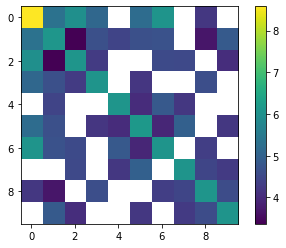

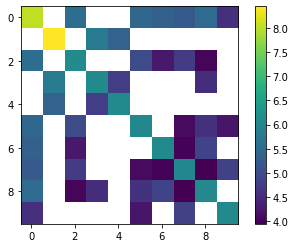

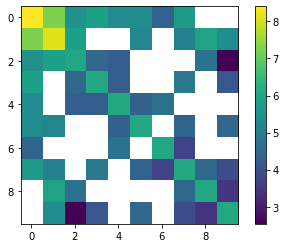

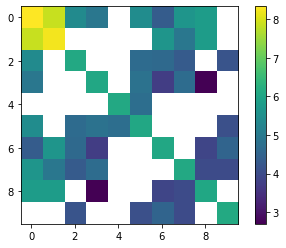

In [169]:
# Plot stationarity for Y
for i in range(n):
    P_Y = V[i].transpose()@t2m(Y.data,i)
    cov = P_Y@P_Y.transpose()
    plt.imshow(np.log10(cov))
    plt.colorbar()
    plt.show()

C:\Users\emres\AppData\Local\Temp/ipykernel_6464/4062485781.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(cov))


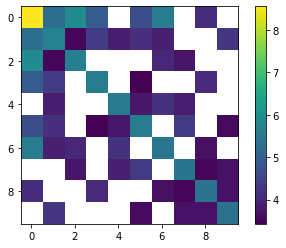

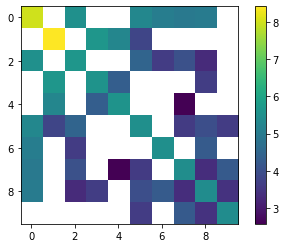

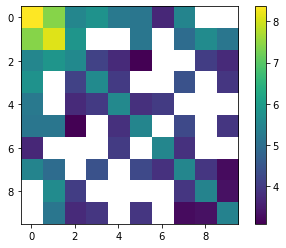

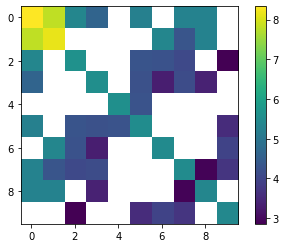

In [170]:
# Plot stationarity for L
for i in range(n):
    P_L = V[i].transpose()@t2m(L,i)
    cov = P_L@P_L.transpose()
    plt.imshow(np.log10(cov))
    plt.colorbar()
    plt.show()

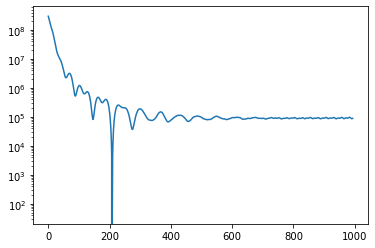

In [171]:
plt.semilogy(fval_tot[7:]-min(fval_tot[7:]))
plt.show()

In [172]:
X_smooth.shape

(10, 10, 10, 10)

In [173]:
# Function value for original X
X_rep = [X_smooth for i in range(n)]
err_orig = fn_val_L(X_smooth, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X_smooth, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X_smooth,i)@t2m(X_smooth,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

orig_fn_val = sum(err_orig + smooth_orig + comm_orig)
print('Function value of original signal: {:.1e}'.format(orig_fn_val))

Function value of original signal: 6.1e+07


In [174]:
# Function value for learned L
L_rep = [L for i in range(n)]
err_l = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_l = fn_val_G(L_rep, L, Phi, Lambda[0], alpha[0], gamma)[1]
l_sigma = [t2m(L,i)@t2m(L,i).transpose() for i in range(n)]
comm_l = fnval_Sigma(l_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

l_fn_val = sum(err_l + smooth_l + comm_l)
print('Function value of the output signal: {:.1e}'.format(l_fn_val))

Function value of the output signal: 2.9e+07


In [175]:
print(err_orig)
print(err_l)

12151369.346830687
3712556.504140001


In [176]:
print(sum(smooth_orig))
print(sum(smooth_l))

12025477.091024563
13270624.97853984


In [177]:
print(sum(comm_orig))
print(sum(comm_l))

554455.2051843052
447042.89174413


In [178]:
# Ymat = t2m(Y.data, 0)
# cov = Ymat@Ymat.transpose()

# fig, ax = plt.subplots(figsize = (15,15))
# im = ax.imshow(cov)

# for i in range(cov.shape[0]):
#     for j in range(cov.shape[1]):
#         text = ax.text(j, i, np.round(np.log10(cov[i, j]), 2) ,
#                        ha="center", va="center", color="w")